In [1]:
#https://www.youtube.com/watch?v=ne-dpRdNReI
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn import preprocessing
from collections import deque, OrderedDict
import random
import fastai
from fastai.structured import add_datepart
from fastai.dataloader import *
from utils.pydataset import *
from utils.blocks import *
from utils.clr import *

from datetime import time

import matplotlib.pyplot as plt
from scipy import signal
%matplotlib inline
# from fastai.old.fastai.column_data import *
# from fastai.metrics import accuracy

In [2]:
use_cuda = torch.cuda.is_available(); print(use_cuda)
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True
CUDA_LAUNCH_BLOCKING=1

True


In [41]:
PATH = Path("../data")
sets = ["BTC-USD", "BCH-USD", "ETH-USD", "LTC-USD"]
wash = True                #Prep raw dataset =False
time = True                #Time as var =False
one_hot = True
base = 'gru'

In [4]:
seq_len = 30 #transactions prior to prediction point
pred_period = 2 #minutes ahead to predict 
pred_ratio = "LTC-USD"
val_pct = .1
bs = 10
epochs = 20

In [48]:
def one_ht(targ):
    if targ == 0:
        return np.array((targ,1))
    elif targ ==1:
        return np.array((targ,0))

def prep_df(df, one_hot=False):
    df = df.copy().drop("future",1)
    
    for col in df.columns.tolist()[13:]:
        if col != "target" and col != f'{col}_close':
            df[col] = df[col].pct_change()
            df.dropna(inplace=True)
            df[col] = preprocessing.scale(df[col].values)
    sequential_data = []
    prev_period = deque(maxlen=seq_len)
    buys = []
    sells = []
    for i in df.values:
        prev_period.append(i[:-1])
        if len(prev_period) == seq_len:
#             sequential_data.append([np.array(prev_period), i[-1]])
            if i[-1] == 0:
                sells.append([np.array(prev_period),np.array(i[-1])])
            elif i[-1] == 1:
                buys.append([np.array(prev_period),np.array(i[-1])])
    print(len(buys),len(sells))
    lower = min(len(buys), len(sells))
    buys = buys[:lower-1]
    sells = sells[:lower-1]
    balanced = buys+sells
    random.shuffle(balanced)
    data = OrderedDict()
    labels = OrderedDict()
    for i, (seq, targ) in enumerate(balanced):
        data[i] = seq
        if one_hot:
            labels[i] = one_ht(targ)
        else:
            labels[i] = targ
    print(f"Total: {len(balanced)}, Buys: {len(buys)}, Sells: {len(sells)}")
    
    return data, labels

def classify(current, future):
    if float(future) > float(current):
        return 1
    else:
        return 0

In [49]:
if wash:
    df_s = [pd.read_csv(PATH / f"{s}.csv",
                        names = ["time","low","high","open",f"{s}_close",f"{s}_volume"],
                        index_col=["time"])
                .drop(["low","high","open"], axis=1) for s in sets]

    
    df_m = pd.concat(df_s, axis=1, join="inner")
    if time:
        df_m.reset_index(inplace=True)
        df_m['time'] = df_m['time'].apply(datetime.datetime.fromtimestamp)
        add_datepart(df_m,'time')
        l = [df_m.columns.tolist()[i] for i in [*range(9,21,1),*range(8)]]
        df_m = df_m.reindex(l, axis=1)
        time = 'time'
    else:
        time = 'proc'
    [df_m[col].replace(False, 0, inplace=True) for col in df_m.columns.tolist()]
    [df_m[col].replace(True, 1, inplace=True) for col in df_m.columns.tolist()]
    df_m["future"] = df_m[f"{pred_ratio}_close"].shift(-pred_period)
    df_m["future"].fillna(method="ffill",inplace=True)
    df_m["target"] = list(map(classify,df_m[f"{pred_ratio}_close"],df_m["future"]))
    if base == '1dsplit':
        l = [*range(12),*range(12,20,2),*range(13,20,2),20,21]
        l = [df_m.columns.tolist()[i] for i in l]
        df_m = df_m.reindex(l, axis=1)
#     df_m.sort_index(inplace=True)
    val_idx = int(len(df_m) * val_pct)
    df_v = df_m.iloc[-val_idx:].copy()
    df_t = df_m.iloc[:-val_idx].copy()
    
    train_x, train_y = prep_df(df_t,one_hot)
    val_x, val_y = prep_df(df_v,one_hot)
    
#     qdf = pd.DataFrame([train_x, train_y]).T
#     qdf.to_pickle(PATH / f'T_{time}_crypto_{base}_{seq_len}_{val_pct * 100}.pkl')
#     qdf = pd.DataFrame([val_x, val_y]).T
#     qdf.to_pickle(PATH / f'V_{time}_crypto_{base}_{seq_len}_{val_pct * 100}.pkl')
else:
    if time:
        time = 'time'
    else:
        time = 'proc'
    df_t= pd.read_pickle(PATH / f'T_{time}_crypto_{seq_len}_{val_pct * 100}.pkl')
    train_x = df_t.loc[:,0].to_dict(OrderedDict)
    train_y = df_t.loc[:,1].to_dict(OrderedDict)
    df_v =pd.read_pickle(PATH / f'V_{time}_crypto_{seq_len}_{val_pct * 100}.pkl') 
    val_x = df_v.loc[:,0].to_dict(OrderedDict)
    val_y = df_v.loc[:,1].to_dict(OrderedDict)

31884 45586
Total: 63766, Buys: 31883, Sells: 31883
3474 5101
Total: 6946, Buys: 3473, Sells: 3473


In [50]:
train_y[0]

array([ 0.,  1.])

In [12]:
class Dataset(data.Dataset):
    def __init__(self, data, labels):
        super().__init__()
        self.data = data
        self.labels = labels
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [51]:
trn_ds = Dataset(train_x, train_y)
val_ds = Dataset(val_x, val_y)

trn_dl = DataLoader(trn_ds, batch_size=bs)
val_dl = DataLoader(val_ds, batch_size=bs)

In [9]:
# class GRU(nn.Module):
#     def __init__(self, h_dim, out_size):
#         super(GRU, self).__init__()
        
#         self.h_dim = h_dim
#         self.out_sz = out_size
        
#         self.gru = nn.GRU(8, self.h_dim)
#         self._lin1 = nn.Linear(self.h_dim * seq_len, self.out_sz)
        
#     def forward(self, input):
#         hidden = self.initHidden(input.shape[1])
#         _, hn = self.gru(input, hidden)
#         ## from (1, N, hidden) to (N, hidden)
#         rearranged = hn.view(bs, -1)
#         out1 = self._lin1(rearranged)
#         return out1
        
#     def initHidden(self, N):
#         return Variable(torch.randn(1, N, self.h_dim))

20

In [169]:
class StdConv1d(nn.Module):
    def __init__(self, nin, nout, n_layers=1, kern=3,
                 stri=1, pad=0, groups=1, bias=True, batch_first=True, loud=False):
        super(StdConv1d,self).__init__()
        self.batch_first = batch_first
        self.loud = loud
        layers = []
        in_chan = nin
        if n_layers > 1:
            for i in range(n_layers-1):
                out_chan = in_chan//(i+1)
                layers.append(nn.Conv1d(in_chan, out_chan, kern, stri, pad, groups=groups, bias=bias))
                layers.append(nn.Dropout(.1))
                in_chan = out_chan
                if loud: print(out_chan)
        layers.append(nn.Conv1d(in_chan, nout, kern, stri, pad, bias=bias))
        self.convs = nn.ModuleList(layers)
        
    def forward(self, x):
        if self.batch_first:
            x = x.permute(0,2,1)
            
        for lay in self.convs:
            x = lay(x)
            if self.loud: print(x.shape)
        
        return x
            

In [257]:
batch, ys = next(iter(trn_dl))
# h = (Variable(torch.zeros(1, bs, 64)),
#           Variable(torch.zeros(1,bs, 64)))
# print(batch.shape)
tst1 = nn.LSTM(8, 64, 1, batch_first=True)
# tst1 = StdConv1d(8,64, pad=1,groups=2)
x, h = tst1(Variable(batch.float()))
# print(h[0].view(bs,-1).shape)
h[0].shape

torch.Size([1, 20, 64])

In [52]:
class Cryptkeeper(nn.Module):
    def __init__(self, n_layers, h_dim,
                 n_sub=2, base='gru', sub='lin'):
        super(Cryptkeeper, self).__init__()
        self.start_dim = self.h_dim = h_dim
        self.n_layers = n_layers
        self.base = base
        self.sub = sub
        self.n_sub = n_sub
        self.nin = len(df_m.columns.tolist())-2
        self.nout = 1
        if one_hot:
            self.nout = 2
        
        assert base in ['gru', 'lstm', '1dsplit']
        assert sub in ['lin', '1d']
        
        if base == 'gru':
            self.gru = nn.GRU(self.nin, h_dim, n_layers, bias=False,batch_first=True)
            self.h_dim = h_dim * self.n_layers
            
        elif base == 'lstm':
            self.lstm = nn.LSTM(self.nin, h_dim, n_layers, batch_first=True)
            self.h_dim = h_dim * self.n_layers
            
            
        elif base == '1dsplit':       #1d split vision, groups=2
            self.primes = StdConv1d(self.nin, h_dim, n_layers,groups=2, pad=1)
            if sub != '1d': self.h_dim = seq_len * h_dim
        
        if sub == 'lin':
            layers = []
            in_chan = self.h_dim
            for i in range(n_sub-1):
                if n_sub < 3:
                    out_chan = in_chan//(i+2)
                else:
                    out_chan = in_chan//(i+1)
                layers.append(StdLinear(in_chan, out_chan))
                in_chan = out_chan
            
            layers.append(nn.Linear(in_chan, self.nout))
            self.subs = nn.ModuleList(layers)
        
            
        elif sub == '1d':
            if base=='1dsplit': 
                lin_dim = self.h_dim * seq_len
            else:
                lin_dim = self.start_dim * n_layers
            self.subs = nn.ModuleList([StdConv1d(self.h_dim, self.start_dim, n_sub, pad=1, batch_first=False),
                         nn.Linear(lin_dim,self.nout)])

    def forward(self, x):        
        h = self._init_hidden(x)
        if self.base == 'gru':
            n = x.size()[0]
            x, h = self.gru(x, h[0])
#             print(h.shape)
            if self.sub == '1d':
                x = x.permute(1,2,0)
            else:
                x = h.permute(1,0,2)
#                 print(x.shape)
                x = x.contiguous().view(n, -1)
                
            
        elif self.base == 'lstm':
            x, h = self.lstm(x, h)
            if self.sub =='1d':
                x = h[0].permute(1,2,0)
                
            else:
                x = h[0].view(x.size()[0], -1)
 
        elif self.base == '1dsplit':
            x = self.primes(x)
            if self.sub != '1d':
                x = x.view(x.size()[0],-1)
        
        if self.sub != '1d':
            
            for lay in self.subs:
                x = lay(x)
                
        else:
            x = self.subs[0](x)
#             print(x.shape)
            x = x.view(x.size()[0], -1)
#             print(x.shape)
            x = self.subs[1](x)
        if  one_hot:
            return F.softmax(x)
        else:
            return F.sigmoid(x)
    
    def _init_hidden(self, x):
        return (Variable(torch.randn(self.n_layers, x.size()[0], self.start_dim)),
                Variable(torch.randn(self.n_layers, x.size()[0], self.start_dim)))

In [15]:
def append_stats(ep_vals, epoch, values, decimals=6):
    ep_vals[epoch]=list(np.round(values, decimals))
    return ep_vals

def print_stats(epoch, values, decimals=3):
    layout = "{!s:^10}" + " {!s:10}" * len(values)
    values = [epoch] + list(np.round(values, decimals))
    print(layout.format(*values))
    
def accuracy(input, targs):
    "Compute accuracy with `targs` when `input` is bs * n_classes."
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    return (input==targs).float().mean()
# from fastai.metrics import accuracy


# names = ["ep / it","trn_loss","val_loss"]
names = ["ep / it", "trn_loss","lwst_trn","val_loss","accuracy"]
layout = "{!s:10} " * len(names)

In [71]:
net = Cryptkeeper(2,128,n_sub=2,base='gru')

use_cuda=False
if use_cuda:
    net.cuda()
    dtype = torch.cuda.FloatTensor
else:
    dtype = torch.FloatTensor
    
lr = 2e-5

optim = torch.optim.Adam(net.parameters(), lr=lr)
# loss = nn.MSELoss()
loss = nn.BCELoss()

scheduler = CyclicLR(optim, lr, mode='triangular2', step_size=len(trn_ds)*2)

In [64]:
val_it = iter(val_dl)
v_bat, v_ys = next(val_it)                
v_bat = Variable(v_bat.type(dtype))
v_ys = Variable(v_ys.type(dtype))
net.eval()
with torch.no_grad():
    v = net(v_bat)
list(zip(v,v_ys))
# accuracy(v,v_ys.long())
# v.shape
# v.argmax(dim=1)

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:93: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[(tensor([ 0.5185,  0.4815]), tensor([ 1.,  0.])),
 (tensor([ 0.5185,  0.4815]), tensor([ 1.,  0.])),
 (tensor([ 0.5185,  0.4815]), tensor([ 1.,  0.])),
 (tensor([ 0.5185,  0.4815]), tensor([ 0.,  1.])),
 (tensor([ 0.5185,  0.4815]), tensor([ 0.,  1.])),
 (tensor([ 0.5185,  0.4815]), tensor([ 0.,  1.])),
 (tensor([ 0.5185,  0.4815]), tensor([ 1.,  0.])),
 (tensor([ 0.5185,  0.4815]), tensor([ 1.,  0.])),
 (tensor([ 0.5185,  0.4815]), tensor([ 1.,  0.])),
 (tensor([ 0.5185,  0.4815]), tensor([ 1.,  0.]))]

In [54]:
# checkpoint = torch.load(PATH / f"checks/Cryptkeeper_{net.base}_{net.sub}_{net.n_layers}x{net.start_dim}_clr.pth.tar")
# checkpoint = torch.load(PATH / f'checks/Cryptkeeper_lstm_5x320_clr.pth.tar')
# if not net.gru.bias:
#     keys = [ "gru.bias_ih_l0", "gru.bias_hh_l0", "gru.bias_ih_l1", "gru.bias_hh_l1"]
#     for key in keys:
#         del checkpoint['state_dict'][key]
# net.load_state_dict(checkpoint['state_dict'])
# optim.load_state_dict(checkpoint['optimizer'])
# scheduler.load_dict(checkpoint['scheduler'])

RuntimeError: Error(s) in loading state_dict for Cryptkeeper:
	Missing key(s) in state_dict: "gru.weight_ih_l3", "gru.weight_hh_l3", "gru.weight_ih_l4", "gru.weight_hh_l4", "subs.0.convs.2.weight", "subs.0.convs.2.bias". 
	While copying the parameter named "subs.1.weight", whose dimensions in the model are torch.Size([1, 320]) and whose dimensions in the checkpoint are torch.Size([1, 192]).

In [ ]:
def save_checkpoint(name, is_best):
    filename =f"{name}_{net.base}_{net.sub}_{net.n_layers}x{net.start_dim}_clr.pth.tar"
    state = {'epoch': epochs,
            'last_epoch': epoch,
            'arch': filename,
            'state_dict': net.state_dict(),
            'losses': [t_ls,v_ls],
            'optimizer': optim.state_dict(),
            'scheduler': scheduler.__dict__}

    torch.save(state,  f'./data/checks/{filename}')
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')
    print('Checkpoint saved.')

In [72]:
t_ls = []
v_ls = []
accs = []
ep_vals = OrderedDict()
window = 500

In [73]:
for epoch in range(epochs):
    if epoch == 0: print(layout.format(*names))
    val_it = iter(val_dl)
    for i, (batch, ys) in enumerate(trn_dl, 0):
        scheduler.batch_step()        
        batch = Variable(batch.type(dtype))
        ys = Variable(ys.type(dtype))
        net.train()
        pred = net(batch)
        if one_hot:
            ls = loss(pred, ys)
        else:
            ls = loss(pred, torch.unsqueeze(ys, dim=1))
        optim.zero_grad()
        ls.backward()
        t_ls.append(ls.item())
        optim.step()
        vals = [np.mean(t_ls[-window:])]

        if i % window == 0:
            net.eval()
            with torch.no_grad():
                v_bat, v_ys = next(val_it)
                
                v_bat = Variable(v_bat.type(dtype))
                v_ys = Variable(v_ys.type(dtype))
                v = net(v_bat)
                if one_hot:
                    v_loss = loss(v,v_ys)
                else:
                    v_loss = loss(v, torch.unsqueeze(v_ys, dim=1))
                v_ls.append(v_loss.item())
                accs.append(accuracy(v, v_ys.long()))
                
#             vals.append(v_loss.item())
            min_t_l = np.min(t_ls[-window:])
            vals.extend((min_t_l, v_loss.item(), np.mean(accs[-window:])))
#             vals.extend((v_loss.item(), np.mean(accs[-3:])))
            print_stats(f"{epoch+1} / {i+1}",vals,4)
    
    save_checkpoint('Cryptkeeper', False)
    ep_vals = append_stats(ep_vals, epoch+1, vals)

ep / it    trn_loss   lwst_trn   val_loss   accuracy   


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:93: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


  1 / 1    0.661      0.661      0.7282     0.5       
 1 / 501   0.6972     0.6136     0.7185     0.5       
 1 / 1001  0.6948     0.61       0.6984     0.5       
 1 / 1501  0.6955     0.6293     0.7493     0.5       
 1 / 2001  0.6967     0.6224     0.7082     0.5       
 1 / 2501  0.6953     0.6368     0.7136     0.5       
 1 / 3001  0.6943     0.6237     0.7042     0.5       
 1 / 3501  0.6943     0.6402     0.6725     0.5       
 1 / 4001  0.6947     0.6454     0.6987     0.5       


KeyboardInterrupt: 

In [19]:
# and accs[-1].detach() >= (accs[-2].detach()+(.2)) 

[tensor(0.4000),
 tensor(0.7000),
 tensor(0.6000),
 tensor(0.8000),
 tensor(0.7000),
 tensor(0.4000),
 tensor(0.7000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.6000),
 tensor(0.4000)]

In [159]:
save_checkpoint('Cryptkeeper', False)

Checkpoint saved.


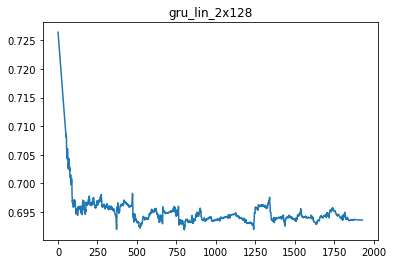

In [69]:
data= t_ls[10:-5]
x = range(len(data))
y = data
plt.title(f'{net.base}_{net.sub}_{net.n_layers}x{net.start_dim}')
plt.plot(x, signal.savgol_filter(y,101,1))
plt.show()

ValueError: x and y must have same first dimension, but have shapes (9357,) and (6057,)

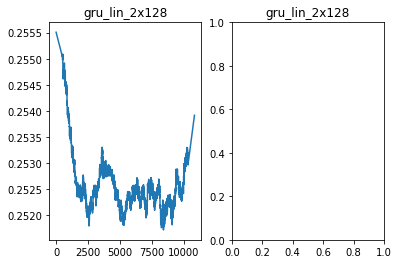

In [39]:
win = 1001
ax = plt.subplot('121')
ax.set_title(f'{net.base}_{net.sub}_{net.n_layers}x{net.start_dim}')
ax.plot(range(len(y)),signal.savgol_filter(y, win, 1))

ax =plt.subplot('122')
data2= t_ls[:len(data2)]
x = range(len(data2))
ax.set_title(f'{net.base}_{net.sub}_{net.n_layers}x{net.start_dim}')
ax.plot(x,signal.savgol_filter(data,win,1))
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
ax1.set_title(f'{net.base}_{net.sub}_{net.n_layers}x{net.start_dim}')
ax1.plot(range(len()))

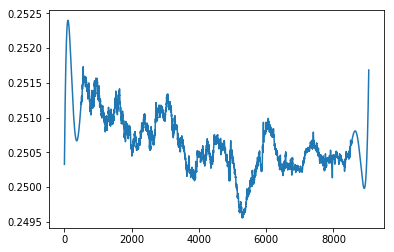

In [190]:
data= t_ls[10:-5]
x = range(len(data))
y = data

plt.plot(x, signal.savgol_filter(y,1001,5))
plt.show()

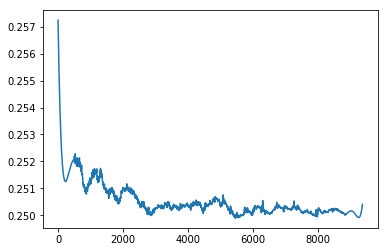

In [40]:
data= t_ls[:-5]
x = range(len(data))
y = data
plt.plot(x, signal.savgol_filter(y,1001,5))
plt.show()

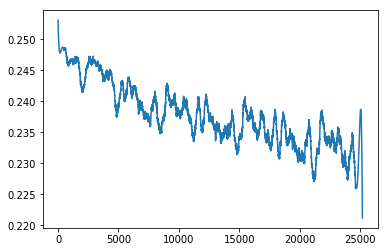

In [66]:
data= t_ls[10:-5]
x = range(len(data))
y = data

plt.plot(x, signal.savgol_filter(y,1001,5))
plt.show()